In [1]:
import sys
import numpy as np
import pandas as pd

from Dissects.io import (load_NDskl, 
                         load_image,
                         load_skeleton,
                         save_skeleton,
                         save_fits
                        )
from Dissects.image import (z_project,
                            thinning,
                            dilation)
from Dissects.geometry import Skeleton
from Dissects.segmentation.seg_2D import (segmentation, 
                                          junction_around_cell,
                                         vertices,
                                         junctions,
                                         generate_mesh)
from Dissects.analysis.analysis import (general_analysis,
                              cellstats
                              )

%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# load image
image, metadata = load_image("/home/admin-suz/Documents/Code/Dissects/Dissects/stores/2d_images.tif")


In [3]:
pixel_ratio = metadata['pixel_ratio']
metadata

{'pixel_ratio': 0.18323109343704702, 'height': 337, 'width': 576}

In [4]:
# metadata={'pixel_ratio': 0.18323109343704702, 'height': 337, 'width': 576}

In [5]:
# #load ndskl file 
# cp, fil, point, specs = load_NDskl("/home/admin-suz/Documents/Code/Dissects/Dissects/stores/2d_images.NDskl.a.NDskl")
# #create skeleton object
# skel = Skeleton(cp, fil, point, specs)


In [6]:
# Load skeleton
data = load_skeleton('2d_skeleton.hf5')
skel = Skeleton(data['critical_point'], data['filament'], data['point'])

/home/admin-suz/miniconda3/lib/python3.7/site-packages/Dissects-0.0.1-py3.7.egg/Dissects/geometry/skeleton.py:25: UserWarning: Has pixel can be half pixel from DisPerSE output,                   we take the integer part of xyz values. 
  we take the integer part of xyz values. ")


In [7]:
#Clean skeleton
skel.remove_lonely_cp()
skel.remove_free_filament()

/home/admin-suz/miniconda3/lib/python3.7/site-packages/Dissects-0.0.1-py3.7.egg/Dissects/geometry/skeleton.py:61: UserWarning: specs dictionnary is not updated, ncrit value is not updated.
  "specs dictionnary is not updated, ncrit value is not updated.")


In [8]:
specs = {'ndims': 2,
 'bbox': np.array([0., 0.]),
 'bbox_delta': np.array([576., 337.]),
 'ncrit': 3525,
 'nfil': 3522}

In [9]:
# Generate mask

skel.specs = specs
mask = skel.create_binary_image()

plt.figure(figsize=(7,7))
plt.imshow(mask, origin='lower')
plt.title('mask')
mask = mask.astype(int)

<IPython.core.display.Javascript object>

In [10]:
# Elargissement
mask_dilation = dilation(mask, 1)
plt.figure(figsize=(7,7))
plt.imshow(mask_dilation, origin='lower')
plt.title('mask_dilation')




<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'mask_dilation')

In [11]:
# Supperposition image originale + masque elargi
fig, ax = plt.subplots()
ax.imshow(image, origin='lower')
y,x = np.where(mask_dilation != 0)
ax.scatter(x,y, alpha=0.2, s=2, color='white')
plt.title('Masque Dilation + image original')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Masque Dilation + image original')

In [12]:
# Background
plt.figure()
plt.imshow((1-mask_dilation) * image, origin='lower')
plt.title('background signal')


#Junction
plt.figure()
plt.imshow(mask_dilation*image, origin='lower')
plt.title('Junctional signal')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Junctional signal')

In [13]:
#from Dissects.analysis import general_analysis
print('mean background =',general_analysis(image, mask_dilation)[0], ',',
      'std =', general_analysis(image, mask_dilation)[1])

print('mean junctional signal=',general_analysis(image, mask_dilation)[2], ',',
      'std =', general_analysis(image, mask_dilation)[3])


mean background = 679.6201338418364 , std = 671.7302549690124
mean junctional signal= 5600.43290185754 , std = 3750.4964749497253


# Vertices méthode Tatiana 



In [14]:
seg = segmentation(mask)

face_df, edge_df, vert_df = generate_mesh(mask, seg, 1, )


In [15]:

plt.figure(figsize=(10,10))
plt.imshow(image, origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
plt.scatter(vert_df['y'], vert_df['x'], color='b')
plt.scatter(face_df['y'], face_df['x'], color='r', marker='+')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


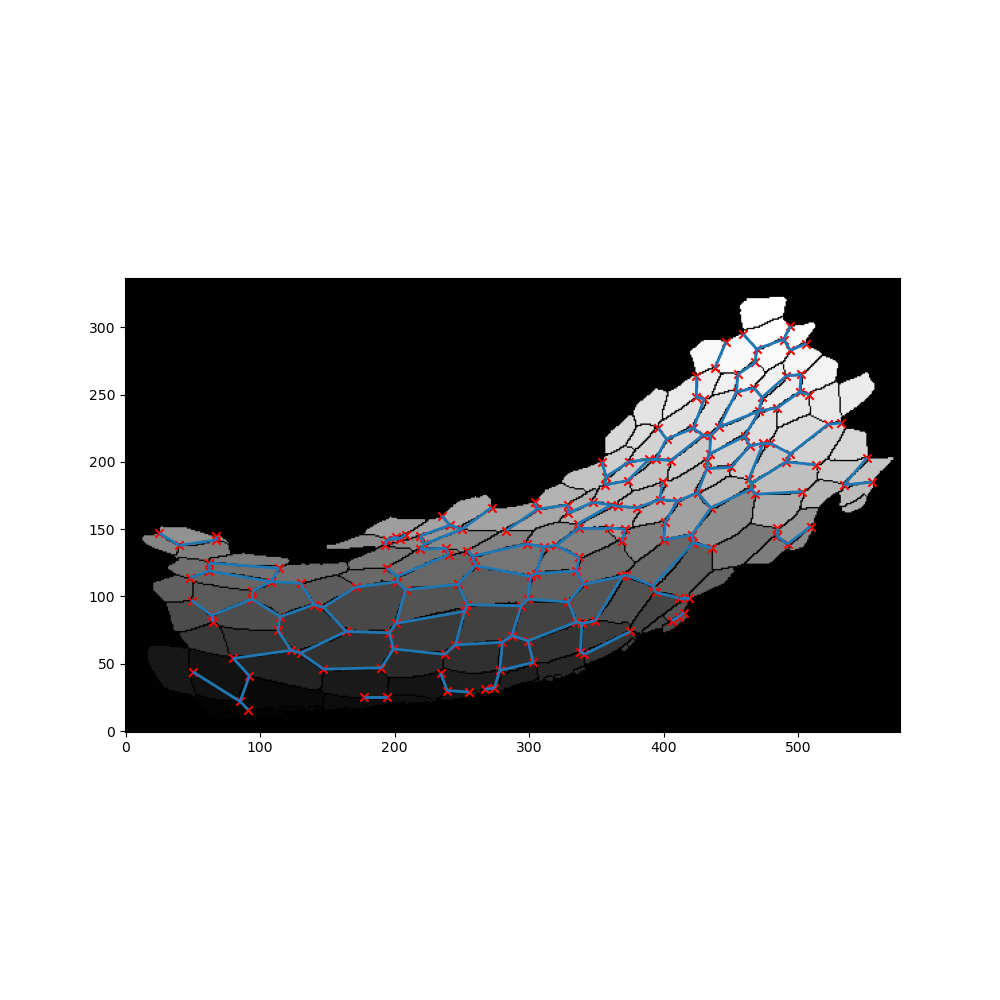

In [16]:
# import numpy as np
import pylab as pl
from matplotlib import collections  as mc

lines=[]
for _, e  in edge_df.iterrows():
    lines.append(([(vert_df['y'][e.v1], vert_df['x'][e.v1]),
                   (vert_df['y'][e.v2], vert_df['x'][e.v2])
                  ]))



cc = vert_df.loc[edge_df['v1']]['x']
lc = mc.LineCollection(lines, cc, cmap='plasma_r', linewidth=2, alpha=1)

fig, ax = pl.subplots(figsize=(10,10))
ax.add_collection(lc)
ax.set_aspect('equal')


plt.imshow(seg, origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
plt.scatter(vert_df['y'], vert_df['x'], color='r', marker='x')
# plt.scatter(face_df['y'], face_df['x'], color='b', marker='+')

In [18]:
image_vertex, list_vertices, df_vertices = vertices(mask, seg, 1)

# Edge detection
df4_jonctions = junctions(list_vertices, df_vertices)

<IPython.core.display.Javascript object>


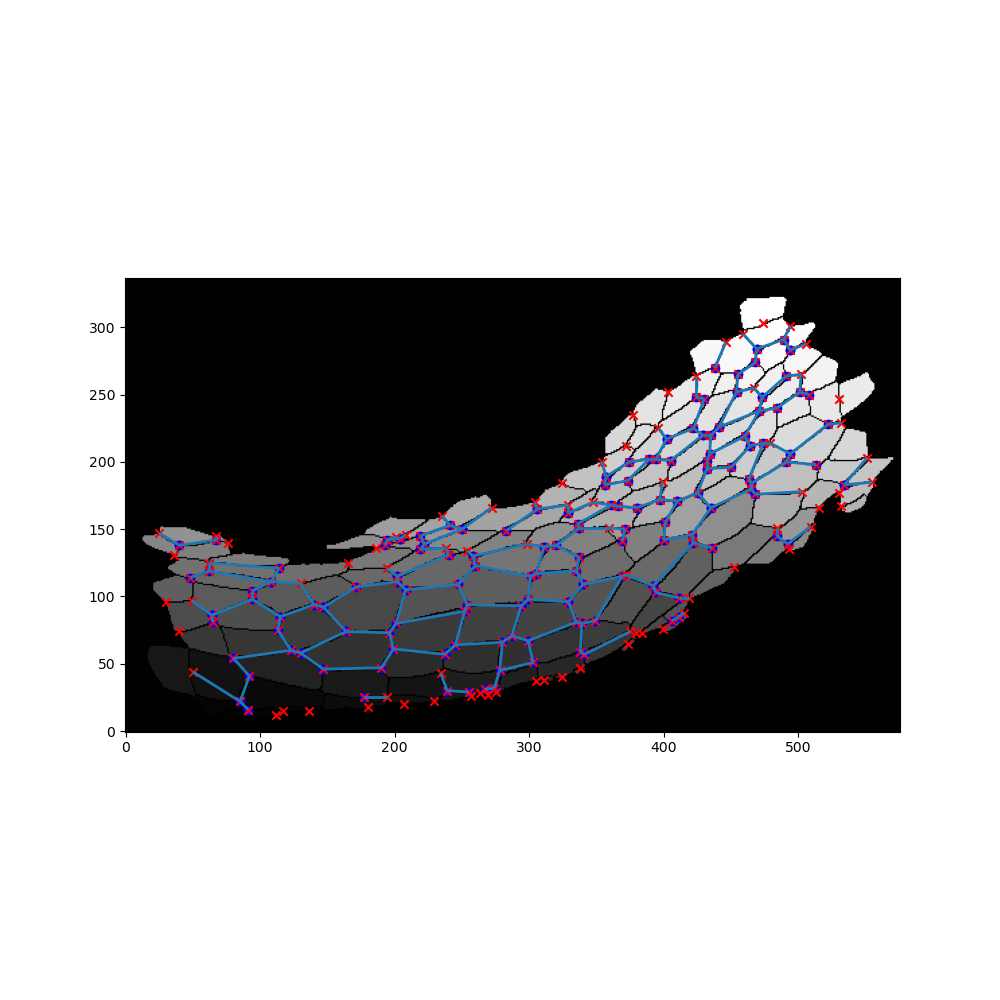

In [19]:
import numpy as np
import pylab as pl
from matplotlib import collections  as mc

lines=[]
for i in range (0, df4_jonctions.shape[0]) :
    lines.append(([(df4_jonctions['y0'][i],df4_jonctions['x0'][i]),
                   (df4_jonctions['y1'][i],df4_jonctions['x1'][i])]))



cc = df4_jonctions['x0']
lc = mc.LineCollection(lines, cc, cmap='plasma_r', linewidth=2, alpha=1)

fig, ax = pl.subplots(figsize=(10,10))
ax.add_collection(lc)
#ax.autoscale()
#ax.margins(0.1)
#ax.scatter(x,y,color='r', zorder=10, s = 7)
ax.set_aspect('equal')

#plt.imshow(image, origin='lower')

plt.imshow(seg, origin='lower',cmap='gist_gray')
ax.set_aspect('equal')
plt.scatter(df4_jonctions['y1'], df4_jonctions['x1'], color='b')
plt.scatter(df_vertices['y_0'], df_vertices['x_0'], color='r', marker='x')